In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# PART 1: Tensors

In [6]:
# Defining tensors

x = torch.tensor([5.5, 3])
print(x)
x = x.new_ones(5, 3, dtype=torch.double)
print(x)
x = torch.rand_like(x, dtype=torch.float)
print(x)
print(x.size())

tensor([5.5000, 3.0000])
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)
tensor([[0.3510, 0.4765, 0.2562],
        [0.3904, 0.7907, 0.6382],
        [0.0614, 0.0880, 0.5733],
        [0.8512, 0.3916, 0.6123],
        [0.0331, 0.6432, 0.5632]])
torch.Size([5, 3])


In [11]:
# Tensor operations

y = torch.rand(5, 3)
print(x + y) #syntax 1
print(torch.add(x, y)) #syntax 2

z = torch.empty(5, 3) # placeholder
torch.add(x, y, out = z)
print(z)

y.add_(x) #in-place addition
print(y)

tensor([[0.9382, 0.6169, 0.4088],
        [0.6153, 1.1015, 0.8095],
        [0.9108, 0.3049, 1.4314],
        [1.2963, 1.1957, 0.7697],
        [0.7171, 1.1440, 1.1137]])
tensor([[0.9382, 0.6169, 0.4088],
        [0.6153, 1.1015, 0.8095],
        [0.9108, 0.3049, 1.4314],
        [1.2963, 1.1957, 0.7697],
        [0.7171, 1.1440, 1.1137]])
tensor([[0.9382, 0.6169, 0.4088],
        [0.6153, 1.1015, 0.8095],
        [0.9108, 0.3049, 1.4314],
        [1.2963, 1.1957, 0.7697],
        [0.7171, 1.1440, 1.1137]])
tensor([[0.9382, 0.6169, 0.4088],
        [0.6153, 1.1015, 0.8095],
        [0.9108, 0.3049, 1.4314],
        [1.2963, 1.1957, 0.7697],
        [0.7171, 1.1440, 1.1137]])


In [14]:
# Tensor indexing and resizing

print(x[:, 1])
y = x.view(15)
z = x.view(-1, 5)
print(x.size(), y.size(), z.size())
print(x[0, 1], x[0, 1].item())

tensor([0.4765, 0.7907, 0.0880, 0.3916, 0.6432])
torch.Size([5, 3]) torch.Size([15]) torch.Size([3, 5])
tensor(0.4765) 0.47650814056396484


## Numpy Bridge

The Torch Tensor and NumPy array will share their underlying memory locations (if the Torch Tensor is on CPU), and changing one will change the other.

In [15]:
# Torch tensor to numpy array

a = torch.ones(5)
b = a.numpy()
a.add_(1)
print(a)
print(b)

tensor([2., 2., 2., 2., 2.])
[2. 2. 2. 2. 2.]


In [16]:
# Numpy array to torch tensor

import numpy as np
a = np.ones(5)
b = torch.from_numpy(a)
np.add(a, 1, out=a)
print(a)
print(b)

[2. 2. 2. 2. 2.]
tensor([2., 2., 2., 2., 2.], dtype=torch.float64)


## CUDA Tensors

In [17]:
#only if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda") # a cuda device object
    y = torch.ones_like(x, device = device) # create a tensor on the GPU
    x = x.to(device)
    z = x + y
    print(z)
    print(z.to("cpu", torch.double))

# PART 2: Autograd

The autograd package provides automatic differentiation for all operations on Tensors. It is a define-by-run framework, which means that your backprop is defined by how your code is run, and that every single iteration can be different.

In [3]:
x = torch.ones(2, 2, requires_grad=True) # track computations on x
y = x + 2
print(y) # y is a Function while x is a Tensor
z = y * y * 3
out = z.mean()
print(z, out)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)
tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


When you finish your computation you can call .backward() and have all the gradients computed automatically. The gradient for this tensor will be accumulated into .grad attribute.

In [4]:
out.backward()
print(x.grad) #d(out)/dx

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


Generally speaking, torch.autograd is an engine for computing vector-Jacobian product. This characteristic of vector-Jacobian product makes it very convenient to feed external gradients into a model that has non-scalar output.

In [5]:
x = torch.randn(3, requires_grad=True)

y = x * 2
while y.data.norm() < 1000:
    y = y * 2

print(y)

v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float) #say v is grad of g wrt y
y.backward(v) 

print(x.grad) # gradient of g wrt x

tensor([-1552.4513,  -795.2225,   913.6493], grad_fn=<MulBackward0>)
tensor([4.0960e+02, 4.0960e+03, 4.0960e-01])


# PART 3: NEURAL NETWORKS

* Neural networks can be constructed using the `torch.nn` package.
* nn depends on `autograd` to define models and differentiate them. An `nn.Module` contains layers, and a method `forward(input)` that returns the `output`.

![title](https://pytorch.org/tutorials/_images/mnist.png)

In [2]:
# NN for digit classification

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        # convolutional kernels with 3x3 filter
        self.conv1 = nn.Conv2d(1, 6, 3) 
        self.conv2 = nn.Conv2d(6, 16, 3)
        
        self.fc1 = nn.Linear(16*6*6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # Max pooling
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [9]:
params = list(net.parameters())
print(len(params))
print(params[0].size()) # weight of conv1

10
torch.Size([6, 1, 3, 3])


Let try a random 32x32 input. Note: expected input size of this net (LeNet) is 32x32. To use this net on MNIST dataset, please resize the images from the dataset to 32x32.

torch.nn only supports mini-batches. The entire `torch.nn` package only supports inputs that are a mini-batch of samples, and not a single sample. For example, `nn.Conv2d` will take in a 4D Tensor of `nSamples x nChannels x Height x Width`. If you have a single sample, just use `input.unsqueeze(0)` to add a fake batch dimension.

In [3]:
test_input = torch.randn(1, 1, 32, 32)
out = net(test_input)
print(out)

tensor([[ 0.0029, -0.1198,  0.0514,  0.0378, -0.0749, -0.0510, -0.0369,  0.0970,
         -0.0115, -0.0200]], grad_fn=<AddmmBackward>)


Zero the gradient buffers of all parameters and backprops with random gradients:

In [13]:
net.zero_grad()
out.backward(torch.randn(1, 10))

In [4]:
# Loss function
output = net(test_input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(1.0722, grad_fn=<MseLossBackward>)


So, when we call loss.backward(), the whole graph is differentiated w.r.t. the loss, and all Tensors in the graph that has requires_grad=True will have their .grad Tensor accumulated with the gradient.

In [16]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

In [5]:
# backprop

net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)


conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([-0.0008, -0.0019, -0.0021,  0.0076, -0.0035,  0.0197])


The simplest update rule used in practice is the Stochastic Gradient Descent (SGD):

`weight = weight - learning_rate * gradient`

In [7]:
# stochastic gradient descent
#learning_rate = 0.01
#for f in net.parameters():
#    f.data.sub_(f.grad.data * learning_rate)

# alternatively
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(test_input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

# PART 4: CLASSIFIER for CIFAR10

This is tutorial from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

* batch size is set to 4

In [12]:
transform = torchvision.transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

100%|█████████▉| 170459136/170498071 [05:57<00:00, 489132.94it/s]

Files already downloaded and verified


170500096it [06:10, 489132.94it/s]                               

truck  deer plane horse


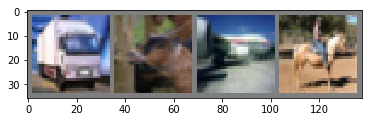

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [15]:
# Now the CNN takes 3 channels

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [18]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.204
[1,  4000] loss: 1.852
[1,  6000] loss: 1.655
[1,  8000] loss: 1.576
[1, 10000] loss: 1.531
[1, 12000] loss: 1.478
[2,  2000] loss: 1.417
[2,  4000] loss: 1.384
[2,  6000] loss: 1.347
[2,  8000] loss: 1.321
[2, 10000] loss: 1.311
[2, 12000] loss: 1.282
Finished Training


In [20]:
print(len(trainset), len(testset))
print(len(trainset)/4, len(testset)/4) # number of mini-batches

50000 10000
12500.0 2500.0


GroundTruth:    cat  ship  ship plane


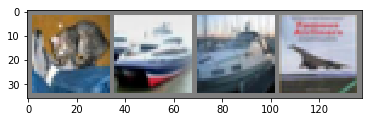

In [21]:
# showing some test images

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [25]:
outputs = net(images) #energies
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


In [28]:
# testing on the test dataset

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


In [29]:
#Error analysis: which class performs OK?

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 39 %
Accuracy of   car : 48 %
Accuracy of  bird : 64 %
Accuracy of   cat : 44 %
Accuracy of  deer : 38 %
Accuracy of   dog : 38 %
Accuracy of  frog : 47 %
Accuracy of horse : 54 %
Accuracy of  ship : 85 %
Accuracy of truck : 67 %
